В этом исследование попробуем предсказать Рак молочной железы, используя 6 алгоритмов:

1. Логистическая регрессия
2. SVM (Метод опорных векторов)
3. Наивный байесовский классификатор
4. Дерево решений
5. Случайный лес
6. Метод К-ближайших соседей


Набор данных включает следующие колонки:
1. mean_radius (среднее значение расстояний от центра до точек по периметру)
2. mean_texture (стандартное отклонение значений шкалы серого цвета)
3. mean_perimeter (периметр образования) 
4. mean_area (площадь образования)
5. mean_smoothness (локальное изменение длины радиуса)
6. diagnosis (1-злокачественные, 0-доброкачественные)

Ссылка на набор данных:https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset

Для сравнения этих методов будем использовать матрицу ошибок.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

## Предобработка данных



In [2]:
data = pd.read_csv('data/Breast_cancer_data.csv')
print('Dataset :',data.shape)
x = data.iloc[:, [0, 1, 2, 3]].values
data.info()
data[0:10]

Dataset : (569, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


**Распределение диагнозов
357 доброжелательные, 212 злокачественные**

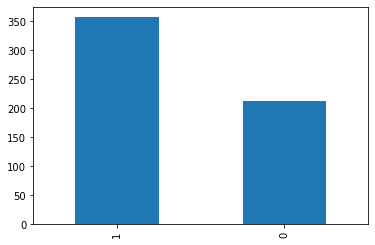

In [3]:
data.diagnosis.value_counts()[0:30].plot(kind='bar')
plt.show()

**Визуализация данных**

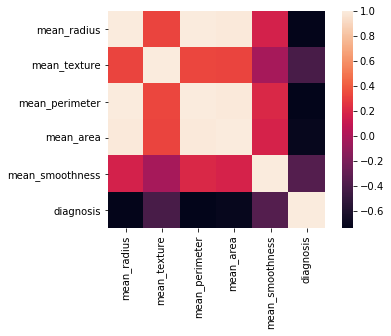

In [4]:
data = data[['mean_radius','mean_texture','mean_perimeter','mean_area', 'mean_smoothness','diagnosis']]
cor = data.corr()
sns.heatmap(cor, square = True)

Как вы можете видеть выше, мы получаем тепловую карту корреляции между переменными. Цветовая палитра сбоку представляет собой величину корреляции между переменными. Более светлый оттенок представляет собой высокую корреляцию.

d:\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


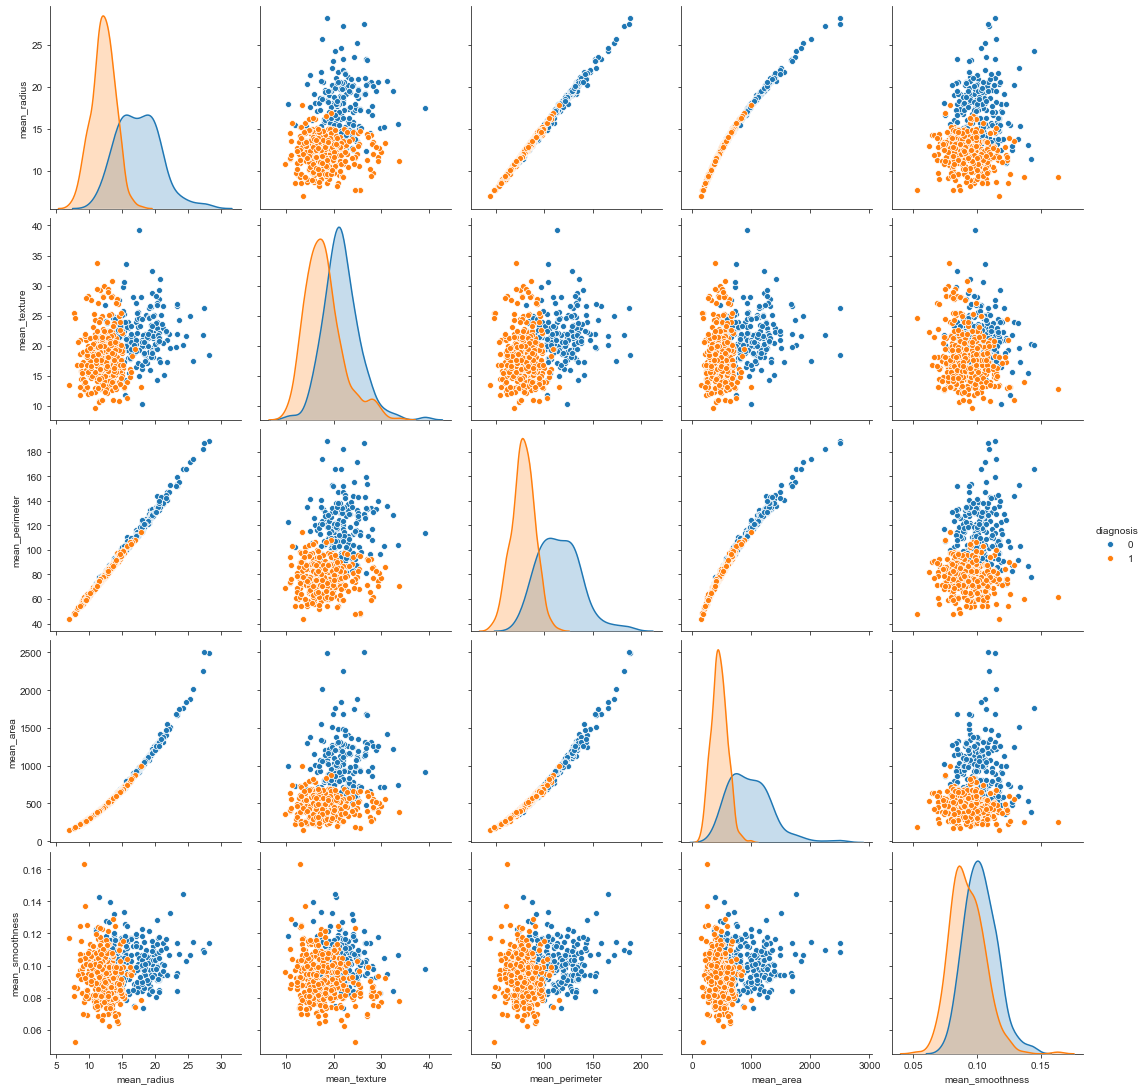

In [5]:
sns.set_style("ticks")
sns.pairplot(data,hue="diagnosis",size=3);
plt.show()

**Данные для обучения и тестирования**

Выберем набор обучающих данных, которые будут вводиться в алгоритм машинного обучения, чтобы убедиться, что алгоритм классификации обучения сможет  хорошо работать на других данных. Для этого исследования будем использовать выборку размером 20%, предположив в ней идеальное соотношение между обучением и тестированием.

In [6]:
from sklearn.model_selection import train_test_split
Y = data['diagnosis']
X = data.drop(columns=['diagnosis'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9)

In [7]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)

X train shape:  (455, 5)
Y train shape:  (455,)
X test shape:  (114, 5)
Y test shape:  (114,)


## 1. Логистическая регрессия

In [8]:
from sklearn.linear_model import LogisticRegression

# Определяем модель
logreg = LogisticRegression(C=10)

# Тренируем модель
logreg.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict1 = logreg.predict(X_test)

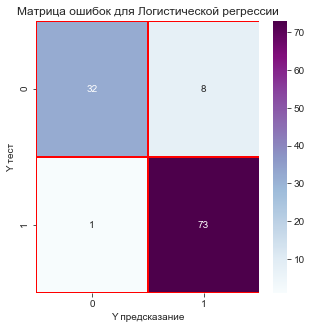

In [9]:
# Матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

logreg_cm = confusion_matrix(Y_test, Y_predict1)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(logreg_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для Логистической регрессии')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [10]:
#Тестовая оценка
score_logreg = logreg.score(X_test, Y_test)
print(score_logreg)

0.9210526315789473


In [11]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict1)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.90


## 2. SVM (Метод опорных векторов)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Определяем модель
svmcla = OneVsRestClassifier(BaggingClassifier(SVC(C=10,kernel='rbf',random_state=9, probability=True), 
                                               n_jobs=-1))

# Тренируем модель
svmcla.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict2 = svmcla.predict(X_test)

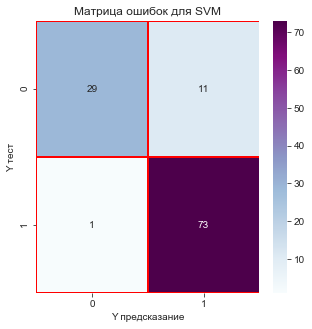

In [13]:
# Матрица ошибок
svmcla_cm = confusion_matrix(Y_test, Y_predict2)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(svmcla_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для SVM')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [14]:
# Тестовая оценка
score_svmcla = svmcla.score(X_test, Y_test)
print(score_svmcla)

0.8947368421052632


In [15]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict2)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.87


## 3. Наивный байесовский классификатор

In [16]:
from sklearn.naive_bayes import GaussianNB

# Определяем модель
nbcla = GaussianNB()

# Тренируем модель
nbcla.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict3 = nbcla.predict(X_test)

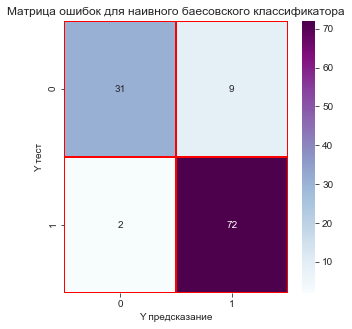

In [17]:
# Матрица ошибок
nbcla_cm = confusion_matrix(Y_test, Y_predict3)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(nbcla_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для наивного баесовского классификатора')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [18]:
# Тестовая оценка
score_nbcla = nbcla.score(X_test, Y_test)
print(score_nbcla)

0.9035087719298246


In [19]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict3)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.88


## 4. Дерево решений

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Определяем модель
dtcla = DecisionTreeClassifier(random_state=9)

# Тренируем модель
dtcla.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict4 = dtcla.predict(X_test)

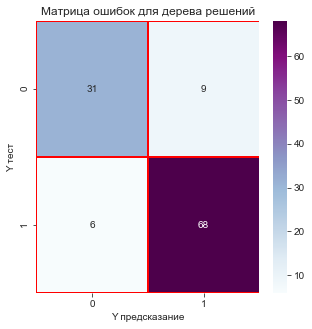

In [21]:
# Матрица ошибок
dtcla_cm = confusion_matrix(Y_test, Y_predict4)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(dtcla_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для дерева решений')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [22]:
# Тестовая оценка
score_dtcla = dtcla.score(X_test, Y_test)
print(score_dtcla)

0.868421052631579


In [23]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict4)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.86


## 5. Случайный лес

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Определяем модель
rfcla = RandomForestClassifier(n_estimators=100,random_state=9,n_jobs=-1)

# Тренируем модель
rfcla.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict5 = rfcla.predict(X_test)

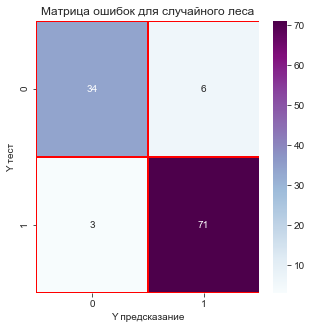

In [25]:
# Матрица ошибок
rfcla_cm = confusion_matrix(Y_test, Y_predict5)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rfcla_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для случайного леса')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [26]:
# Тестовая оценка
score_rfcla = rfcla.score(X_test, Y_test)
print(score_rfcla)

0.9210526315789473


In [27]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict5)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.91


## 6. Метод К-ближайших соседей

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Определяем модель
knncla = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

# Тренируем модель
knncla.fit(X_train, Y_train)

# Прогнозируем целевые значения
Y_predict6 = knncla.predict(X_test)

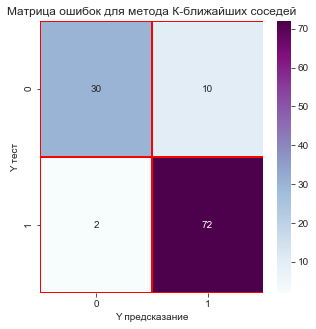

In [35]:
# Матрица ошибок
knncla_cm = confusion_matrix(Y_test, Y_predict6)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(knncla_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Матрица ошибок для метода К-ближайших соседей')
plt.xlabel('Y предсказание')
plt.ylabel('Y тест')
plt.show()

In [30]:
# Тестовая оценка
score_knncla= knncla.score(X_test, Y_test)
print(score_knncla)

0.8947368421052632


In [31]:
#Точность
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_predict6)

print('Средняя оценка точности: {0:0.2f}'.format(
      average_precision))

Средняя оценка точности: 0.87


# Сравнение методов классификации

### Оценка точности

In [36]:
Testscores = pd.Series([score_logreg, score_svmcla, score_nbcla, score_dtcla, score_rfcla, score_knncla], 
                        index=['Логистическая регрессия', 'SVM (Метод опорных векторов)', 'Наивный байесовский классификатор', 'Дерево решений', 'Случайный лес', 'Метод К-ближайших соседей']) 
print(Testscores)

Логистическая регрессия              0.921053
SVM (Метод опорных векторов)         0.894737
Наивный байесовский классификатор    0.903509
Дерево решений                       0.868421
Случайный лес                        0.921053
Метод К-ближайших соседей            0.894737
dtype: float64


### Матрицы ошибок

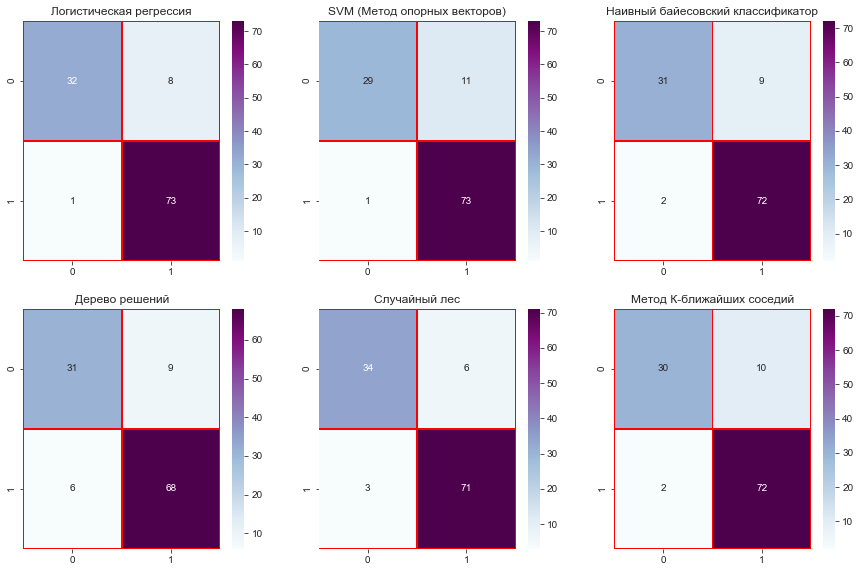

In [33]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3, 3, 1) 
ax1.set_title('Логистическая регрессия') 
ax2 = fig.add_subplot(3, 3, 2) 
ax2.set_title('SVM (Метод опорных векторов)')
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Наивный байесовский классификатор')
ax4 = fig.add_subplot(3, 3, 4)
ax4.set_title('Дерево решений')
ax5 = fig.add_subplot(3, 3, 5)
ax5.set_title('Случайный лес')
ax6 = fig.add_subplot(3, 3, 6)
ax6.set_title('Метод К-ближайших соседей')
sns.heatmap(data=logreg_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax1)
sns.heatmap(data=svmcla_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax2)  
sns.heatmap(data=nbcla_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax3)
sns.heatmap(data=dtcla_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax4)
sns.heatmap(data=rfcla_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax5)
sns.heatmap(data=knncla_cm, annot=True, linewidth=0.7, linecolor='red',cmap="BuPu" ,fmt='g', ax=ax6)
plt.show()

Лучше всего справлись Линейная регрессия и Случайный лес

### ROC кривая

Исходя из сравнения методов классификации, мы строим ROC, чтобы проиллюстрировать диагностическую способность бинарной классификаторной системы, поскольку ее порог дискриминации изменяется.

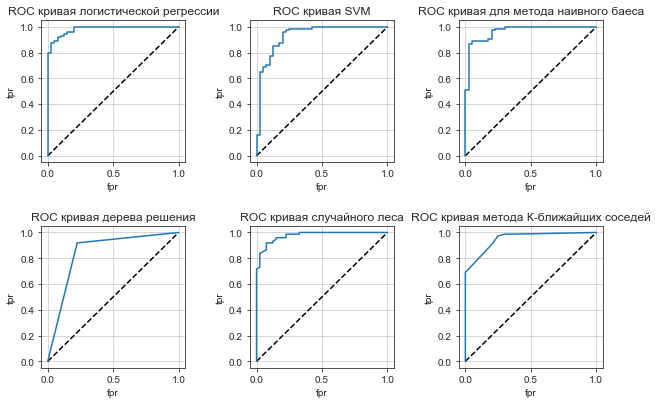

In [41]:
from sklearn.metrics import roc_curve

# Логистическая регрессия
Y_predict1_proba = logreg.predict_proba(X_test)
Y_predict1_proba = Y_predict1_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict1_proba)
plt.subplot(331)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая логистической регрессии')
plt.grid(True)

# SVM (Метод опорных векторов)
Y_predict2_proba = svmcla.predict_proba(X_test)
Y_predict2_proba = Y_predict2_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict2_proba)
plt.subplot(332)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая SVM')
plt.grid(True)

# Наивный байесовский классификатор
Y_predict3_proba = nbcla.predict_proba(X_test)
Y_predict3_proba = Y_predict3_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict3_proba)
plt.subplot(333)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая для метода наивного баеса')
plt.grid(True)

# Дерево решений
Y_predict4_proba = dtcla.predict_proba(X_test)
Y_predict4_proba = Y_predict4_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict4_proba)
plt.subplot(334)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая дерева решения')
plt.grid(True)

# Случайный лес
Y_predict5_proba = rfcla.predict_proba(X_test)
Y_predict5_proba = Y_predict5_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict5_proba)
plt.subplot(335)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая случайного леса')
plt.grid(True)

# Метод К-ближайших соседий
Y_predict6_proba = knncla.predict_proba(X_test)
Y_predict6_proba = Y_predict6_proba[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict6_proba)
plt.subplot(336)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC кривая метода К-ближайших соседей')
plt.grid(True)
plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=1.4, hspace=0.45, wspace=0.45)
plt.show()